In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Deep Learning Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# ==========================================
# 1. LOAD DATASET
# ==========================================
# Pastikan path file sudah sesuai dengan lokasi di Google Drive Anda
# Mengatasi FileNotFoundError: file tidak ditemukan di lokasi '/content/heart_disease_uci.csv'.
# Solusi umum di Google Colab adalah:
# 1. Pastikan file 'heart_disease_uci.csv' telah diupload ke lingkungan Colab (misalnya ke direktori /content/).
# ATAU
# 2. Jika file ada di Google Drive Anda, mount Google Drive dan sesuaikan path.

from google.colab import drive
drive.mount('/content/drive')

# Mengubah path file ke lokasi di Google Drive setelah dimount
# Pastikan nama file dan path di Google Drive Anda sudah benar.
# Contoh: Jika file berada langsung di 'My Drive' Anda
file_path = '/content/drive/MyDrive/Colab Notebooks/uas deep learning/heart_disease_uci.csv'

df = pd.read_csv(file_path)

print("Info Dataset Awal:")
print(df.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Info Dataset Awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memor

In [ ]:
# ==========================================
# 2. DATA PREPROCESSING (PEMBERSIHAN)
# ==========================================

# A. Hapus kolom yang tidak relevan untuk prediksi medis
# 'id' hanya penomoran, 'dataset' adalah lokasi asal data (bisa bias)
df = df.drop(['id', 'dataset'], axis=1)

# B. Menangani Target Variable ('num')
# Aslinya: 0 (sehat), 1,2,3,4 (tingkat keparahan sakit)
# Kita ubah jadi Binary Classification: 0 = Sehat, 1 = Ada Penyakit Jantung
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df = df.drop('num', axis=1) # Hapus kolom num lama

print(f"\nDistribusi Target (0=Sehat, 1=Sakit):\n{df['target'].value_counts()}")

# C. Memisahkan Kolom Kategorikal dan Numerik
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove('target') # Target tidak perlu discaling

# D. Handling Missing Values (Data Hilang)
# Untuk numerik: isi dengan median
imputer_num = SimpleImputer(strategy='median')
df[numerical_cols] = imputer_num.fit_transform(df[numerical_cols])

# Untuk kategorikal: isi dengan modus (nilai yang paling sering muncul)
imputer_cat = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = imputer_cat.fit_transform(df[categorical_cols])

# E. Encoding Data Kategorikal
# Menggunakan One-Hot Encoding (get_dummies) untuk mengubah teks menjadi angka 0/1
df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


Distribusi Target (0=Sehat, 1=Sakit):
target
1    509
0    411
Name: count, dtype: int64


In [ ]:
# ==========================================
# 3. SPLIT & SCALING
# ==========================================

X = df_processed.drop('target', axis=1)
y = df_processed['target']

# Split Data: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling (Wajib untuk Deep Learning)
# Ini membuat range angka seperti 'chol' (200-500) setara dengan 'oldpeak' (0-5)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nDimensi Data Training: {X_train_scaled.shape}")
print(f"Dimensi Data Testing: {X_test_scaled.shape}")


Dimensi Data Training: (736, 18)
Dimensi Data Testing: (184, 18)


In [ ]:
# =========================================
# 4. PERSIAPAN DATA & MEMBANGUN MODEL CNN (1D)
# =========================================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. RESHAPE DATA UNTUK CNN
# CNN butuh input 3D: (Jumlah Data, Jumlah Fitur, 1)
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print(f"Shape data untuk CNN: {X_train_cnn.shape}")

# 2. MEMBANGUN MODEL
tf.keras.backend.clear_session()
model = Sequential()

# --- Layer Konvolusi 1 ---
# Filters=32: Mencari 32 jenis pola
# Kernel_size=3: Melihat 3 fitur sekaligus secara berurutan
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2)) # Mengambil nilai terbesar dari area pooling (memperkecil data)

# --- Layer Konvolusi 2 ---
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# --- Flatten ---
# Mengubah hasil konvolusi (matriks) menjadi vektor lurus agar bisa masuk ke Dense layer
model.add(Flatten())

# --- Fully Connected Layer (Sama seperti ANN biasa) ---
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5)) # Mencegah overfitting

# --- Output Layer ---
model.add(Dense(1, activation='sigmoid')) # Klasifikasi Biner

# Compile
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Shape data untuk CNN: (736, 18, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 16, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 6, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,753 (73.25 KB)

 Trainable params: 18,753 (73.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 5. TRAINING MODEL CNN
# =========================================

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15, # Kita beri toleransi lebih lama untuk CNN belajar
    restore_best_weights=True,
    verbose=1
)

# Perhatikan kita menggunakan X_train_cnn dan X_test_cnn (yang sudah di-reshape)
history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5738 - loss: 0.6756 - val_accuracy: 0.7717 - val_loss: 0.5277
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7862 - loss: 0.5134 - val_accuracy: 0.8207 - val_loss: 0.4212
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8076 - loss: 0.4506 - val_accuracy: 0.7989 - val_loss: 0.4182
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7813 - loss: 0.4882 - val_accuracy: 0.8315 - val_loss: 0.3837
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8078 - loss: 0.4313 - val_accuracy: 0.8478 - val_loss: 0.3593
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7800 - loss: 0.4496 - val_accuracy: 0.8533 - val_loss: 0.3586
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8243 - loss: 0.3969 - val_accuracy: 0.8587 - val_loss: 0.3548
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8172 - loss: 0.3945 - val_accuracy: 0.84

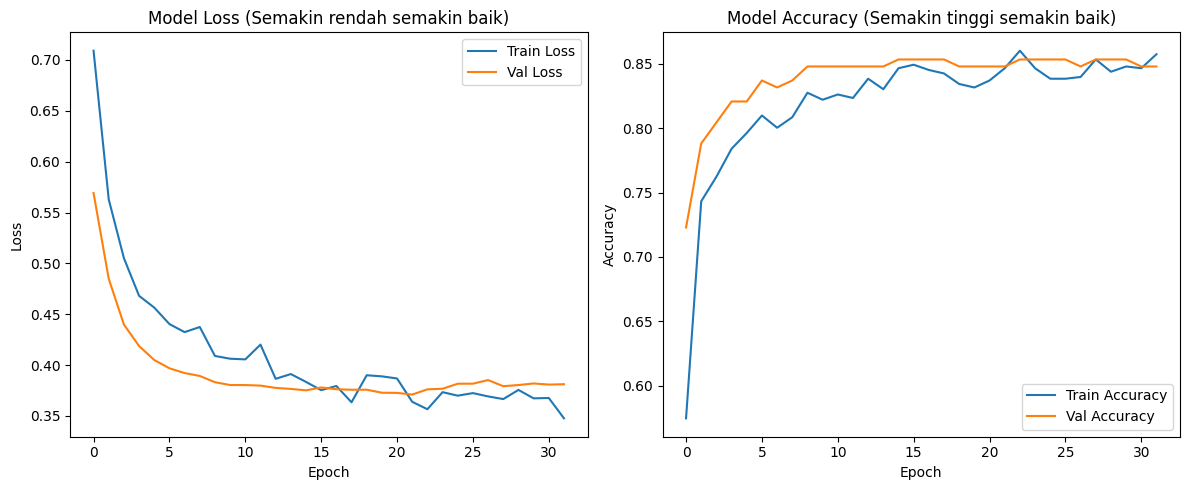

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8178 - loss: 0.4294 

=== Hasil Evaluasi Akhir ===
Loss: 0.3811
Akurasi: 84.78%


In [ ]:
# ==========================================
# 6. EVALUASI & VISUALISASI
# ==========================================

# Plot Akurasi dan Loss
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (Semakin rendah semakin baik)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy (Semakin tinggi semakin baik)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluasi Akhir
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\n=== Hasil Evaluasi Akhir ===")
print(f"Loss: {loss:.4f}")
print(f"Akurasi: {accuracy*100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


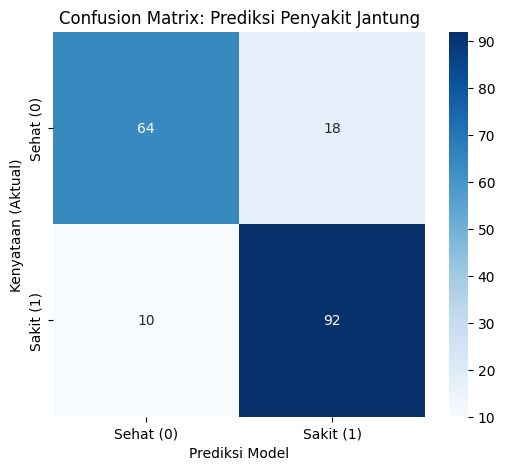


=== Laporan Klasifikasi Detail ===
              precision    recall  f1-score   support

       Sehat       0.86      0.78      0.82        82
       Sakit       0.84      0.90      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Lakukan Prediksi pada Data Test
# Model mengeluarkan probabilitas (0.0 - 1.0), kita bulatkan: <0.5 = 0, >=0.5 = 1
y_pred = model.predict(X_test_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)

# 2. Buat Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)

# 3. Visualisasi Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sehat (0)', 'Sakit (1)'],
            yticklabels=['Sehat (0)', 'Sakit (1)'])
plt.xlabel('Prediksi Model')
plt.ylabel('Kenyataan (Aktual)')
plt.title('Confusion Matrix: Prediksi Penyakit Jantung')
plt.show()

# 4. Tampilkan Laporan Klasifikasi (Precision, Recall, F1-Score)
print("\n=== Laporan Klasifikasi Detail ===")
print(classification_report(y_test, y_pred_binary, target_names=['Sehat', 'Sakit']))

ℹ️ Menggunakan data X_test_cnn
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


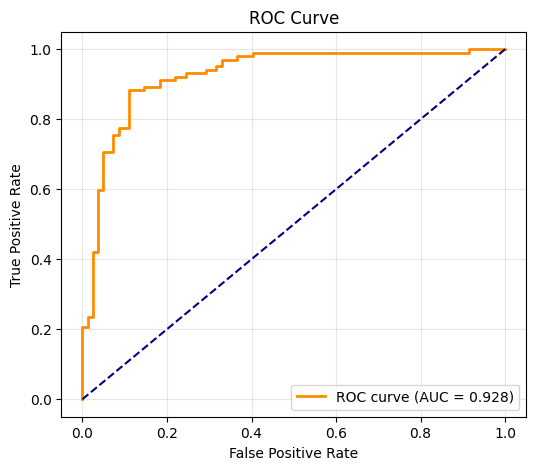

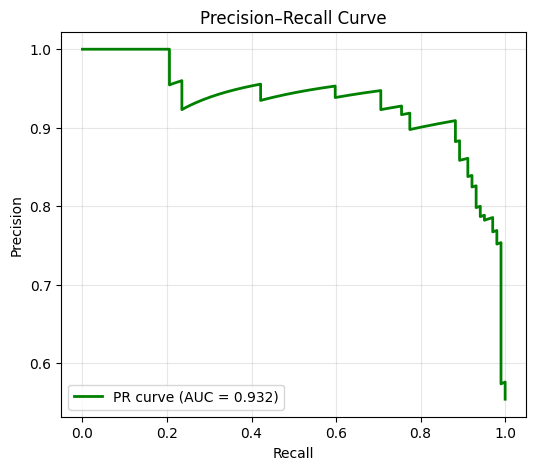

In [ ]:
# =========================================
# EVALUASI LENGKAP: ROC-AUC & PRECISION-RECALL
# =========================================

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# 1. SIAPKAN DATA & PREDIKSI
# -----------------------------------------
# Cek apakah kita punya data versi CNN atau ANN biasa
if 'X_test_cnn' in globals():
    print("ℹ️ Menggunakan data X_test_cnn")
    input_data = X_test_cnn
    # Pastikan bentuknya 3D jika modelnya CNN
    if len(input_data.shape) == 2:
        input_data = input_data.reshape(input_data.shape[0], input_data.shape[1], 1)
else:
    print("ℹ️ Menggunakan data X_test_scaled (ANN Biasa)")
    input_data = X_test_scaled

# Prediksi Probabilitas (Hasilnya angka 0.0 s.d 1.0)
y_prob = model.predict(input_data).ravel()

# 2. PLOT 1: ROC CURVE
# -----------------------------------------
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], color='navy', linestyle="--") # Garis diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# 3. PLOT 2: PRECISION-RECALL CURVE
# -----------------------------------------
prec, rec, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(rec, prec)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, color='green', lw=2, label=f"PR curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# =========================================
# 8. SIMPAN MODEL UNTUK APLIKASI FLASK
# =========================================
import joblib
import pickle
import numpy as np

# 1. Simpan Model CNN (.h5)
# Nama file disesuaikan dengan request kode Flask Anda: 'heart_disease_model.h5'
model.save('heart_disease_model.h5')

# 2. Simpan Scaler (untuk normalisasi data input nanti)
# Pastikan variabel 'scaler' berasal dari proses training sebelumnya
joblib.dump(scaler, 'scaler.pkl')

# 3. Simpan Nama Kolom (PENTING!)
# Agar urutan kolom di aplikasi sama persis dengan saat training
# Asumsi: variabel 'X' adalah dataframe fitur setelah pd.get_dummies tapi sebelum scaling
# Jika Anda menggunakan nama lain (misal X_encoded), ganti 'X' di bawah ini
model_columns = X.columns.tolist()

with open('model_columns.pkl', 'wb') as f:
    pickle.dump(model_columns, f)

print("✅ BERHASIL DISIMPAN!")
print("Silakan download 3 file ini dari folder Colab dan upload ke folder proyek Flask Anda:")
print("1. heart_disease_model.h5")
print("2. scaler.pkl")
print("3. model_columns.pkl")

✅ BERHASIL DISIMPAN!
Silakan download 3 file ini dari folder Colab dan upload ke folder proyek Flask Anda:
1. heart_disease_model.h5
2. scaler.pkl
3. model_columns.pkl
